In [1]:
import pygsp as p

import numpy as np
from numpy.linalg import matrix_rank, inv, pinv
import matplotlib.pyplot as plt

import cv2

from scipy import fft

from scipy.sparse.linalg import eigs
from scipy.linalg import eig

In [2]:
# from ripser import ripser
# from persim import plot_diagrams

In [3]:
data_rs = np.random.RandomState(12845)
signal_rs = np.random.RandomState(12345)
signal_grid_rs = np.random.RandomState(12745)


In [4]:
# função que define os dados
def start_points(n = 100, r = 1, eps = 0.2, rs = data_rs):
    ps = []
    n = 100
    for i in range(n):
        theta = rs.uniform(0, 2 * np.pi)
        eps = rs.uniform(-0.2, 0.2)
        x, y  = (r + eps) * np.cos(theta), (r + eps) * np.sin(theta)
        ps += [[x,y]]
    return np.array([np.array(q) for q in ps])

In [5]:
data = start_points()

In [6]:
# diagrams = ripser(data, thresh=1)['dgms'] #thresh é maior valor de epsilon que a função considera

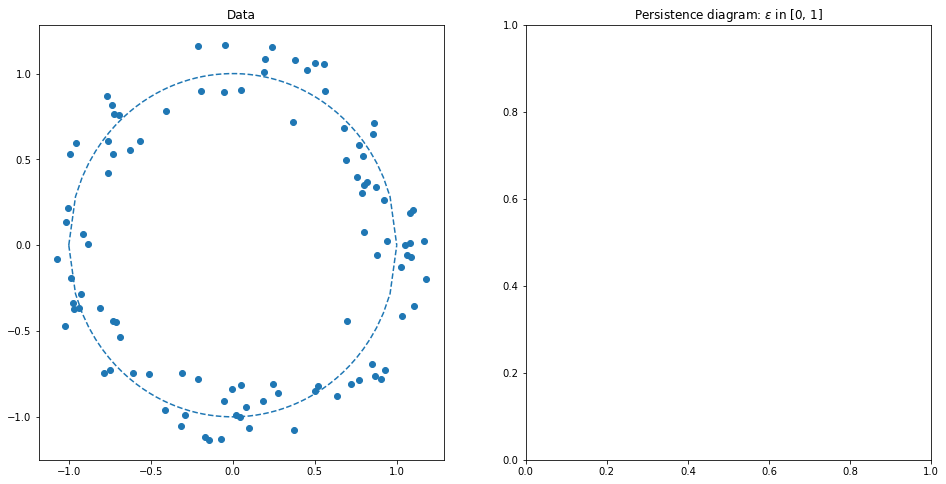

In [7]:
# verificando que os pontos estão perto de um círculo
fig, ax = plt.subplots(1, 2, figsize = (16,8))

ax[0].set_title('Data')
ax[1].set_title(r'Persistence diagram: $\epsilon$ in [0, 1]')

ax[0].scatter([q[0] for q in data], [q[1] for q in data])
ax[0].plot(np.linspace(-1,1), np.sqrt(1 - np.linspace(-1, 1) ** 2), '--', color = 'tab:blue')
ax[0].plot(np.linspace(-1,1), -np.sqrt(1 - np.linspace(-1, 1) ** 2), '--', color = 'tab:blue')
# plot_diagrams(diagrams, show=True)

plt.show()

In [8]:
eps = 0.4
G = p.graphs.NNGraph(Xin = data, NNtype = 'radius', epsilon = eps)

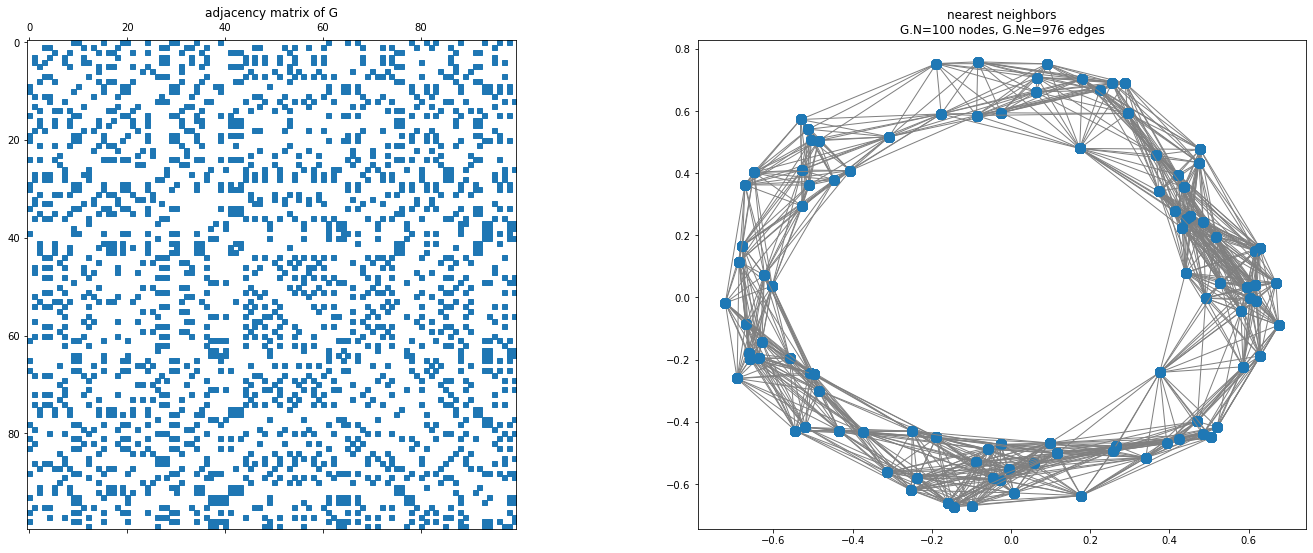

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (24, 9))
ax[0].spy(G.W, markersize=5)
G.plot(ax=ax[1])

ax[0].set_title("adjacency matrix of G")
plt.show()

In [10]:
def start_graph(reference_operator, G):
    
    if reference_operator == 'laplacian':
        G.compute_fourier_basis()
        V = G.U
        Λ = np.diag(G.e)

    if reference_operator == 'adjacency':
        λs, vs = np.linalg.eig(G.W.todense())
        V = vs
        Λ = np.diag(λs)

    G.V = np.array(V)
    G.Λ = Λ

def optimal_sampling_operator(V, k, m, sort = True, verbose = False):
    Vk = V[:, :k]
    M = []
    n = np.shape(Vk)[0]
    check_list = list(np.arange(0, n, 1, dtype = int))
    while len(M) < m:
        c = 0
        i = 0
        for j in check_list:
            if j in M:
                continue
            d = min(np.linalg.svd(Vk[M + [i]])[1])
            if d >= c:
                i = j
                c = d
        check_list.remove(i)
        M += [i]
        if verbose:
            print(len(check_list))
    if sort:
        M.sort()
    return M    

def setup(reference_operator, G, indexes):
    '''
    reference_operator = laplacian or adjacency
    G the graph
    indexes the indexes of the samples
    it is assumed that the number of collumns given is equal to the length of indexes
    ψ sampling matrix
    U inverse of ψVk
    φ interpolation matrix
    
    return: V, Λ, ψ, U, φ
    '''
    
    start_graph(reference_operator, G)
        
    m = np.shape(G.V)[0]
    k = len(indexes) #number of samples
    ψ = np.zeros((k, np.shape(G.V)[0]))
    for i, o_i in enumerate(indexes):
        ψ[i][o_i] = 1
    U = inv(ψ @ G.V[:, :k])
    φ = G.V[:, :k] @ U
    return G.V, G.Λ, ψ, U, φ

def sampling_matrix(V, indexes):
    ψ = np.zeros((np.shape(V)[0], np.shape(V)[0]))
    for i in indexes:
        ψ[i][i] = 1
    return ψ

def make_signal(rs, G, k):
    coefs = rs.uniform(10 * np.ones(k))
    signal = np.array(G.V[:, :k] @ coefs).reshape(G.N,)
    return signal

# Adjacency matrix example "data around circle" graph

In [11]:
k = 15
reference_operator = 'adjacency'
start_graph(reference_operator, G)

In [12]:
opt_indexes = optimal_sampling_operator(G.V, k, k, sort = False)

In [13]:
V, Λ, ψ, U, φ = setup(reference_operator, G, opt_indexes)
ψ_sampling = sampling_matrix(G.V, opt_indexes)
M = φ @ ψ

In [14]:
signal = make_signal(signal_rs, G, k)
reconstructed_signal = M @ signal

In [15]:
np.shape(V), np.shape(Λ), np.shape(ψ), np.shape(U), np.shape(φ), np.shape(signal) #tamanhos certos

((100, 100), (100, 100), (15, 100), (15, 15), (100, 15), (100,))

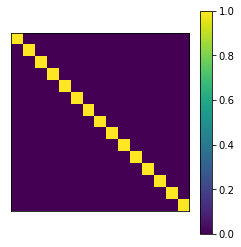

In [16]:
plt.matshow(U @ ψ @ V[:, :k]) # U ψ Vk é a matriz identidade
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [17]:
h = [j in opt_indexes for j in np.arange(0,  G.N, 1)]

In [18]:
ax?

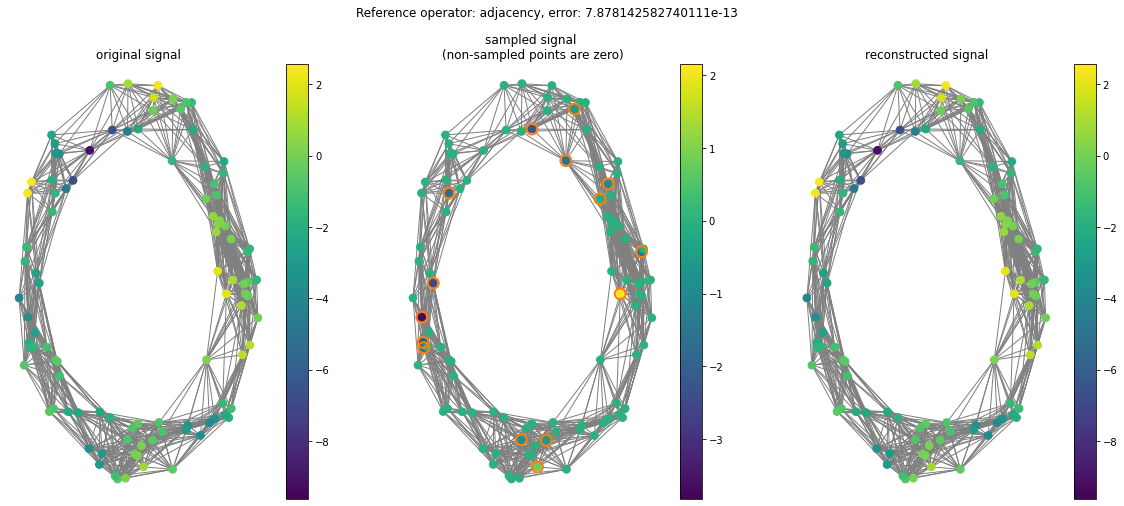

In [19]:
fig, ax = plt.subplots(1,3, figsize = (20,8))

titles = ['original signal', 'sampled signal \n(non-sampled points are zero)', 'reconstructed signal']
signals = [signal, ψ_sampling @ signal, reconstructed_signal]
hs = [G.N * [False], [j in opt_indexes for j in np.arange(0,  G.N, 1)], G.N * [False]]

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].axis('off')
    G.plot_signal(signals[i], vertex_size = 60, highlight = hs[i], ax = ax[i],)
    ax[i].set_title(titles[i])
    
fig.suptitle(f'Reference operator: % s, error: ' % (reference_operator) + str(max(np.abs(signal - reconstructed_signal))))
plt.show()

In [20]:
(np.hstack((U @ ψ @ signal, 0 * np.ones(G.N - k))) - V.T @ signal).max() #frequencias "iguais"

3.2596148002994596e-13

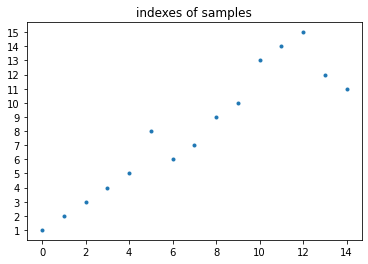

In [21]:
# plt.figure(figsize = (10,10))
plt.plot(opt_indexes, '.')
plt.yticks(opt_indexes)
plt.title('indexes of samples')
plt.show()

# Grid graph

In [22]:
a, b = 35, 35
H = p.graphs.Grid2d(a,b)
grid_k = 4
reference_operator_grid = 'adjacency'

In [23]:
start_graph(reference_operator_grid, H)

In [24]:
opt_indexes_grid = optimal_sampling_operator(H.V, grid_k, grid_k)

In [25]:
V_grid, Λ_grid, ψ_grid, U_grid, φ_grid = setup(reference_operator_grid, H, opt_indexes_grid)
ψ_sampling_grid = sampling_matrix(H.V, opt_indexes_grid)
M_grid = φ_grid @ ψ_grid

In [26]:
signal_grid = make_signal(signal_grid_rs, H, grid_k)
reconstructed_signal_grid = M_grid @ signal_grid

In [27]:
h_grid = [j in opt_indexes_grid for j in np.arange(0, H.N, 1)]

In [28]:
opt_indexes_grid

[1, 3, 5, 10]

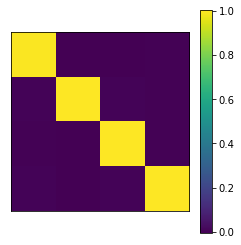

In [29]:
plt.matshow(U_grid.real @ ψ_grid @ V_grid.real[:, :grid_k]) # U ψ Vk é a matriz identidade
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

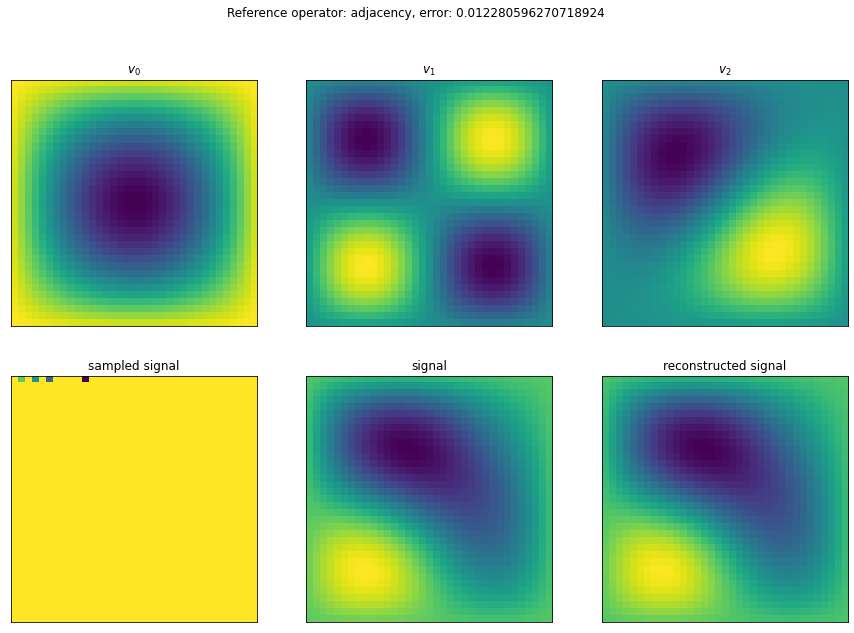

In [30]:
titles = [r'$v_{%s}$' % (0),
          r'$v_{%s}$' % (1),
          r'$v_{%s}$' % (2),
          'sampled signal',
#           r'$v_{%s}$' % (opt_indexes_grid[3]),
          'signal',
          'reconstructed signal']
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
signals_grid = [H.V.real[:, 0], 
           H.V.real[:, 1],
           H.V.real[:, 2],
           (ψ_sampling_grid @ signal_grid).real,
#            H.V[:, opt_indexes_grid[3]],
           signal_grid.real,
           reconstructed_signal_grid.real]

for i in [0,1]:
    for j in [0,1,2]:

#         ax[i][j].axis('off')
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
#         H.plot_signal(signals_grid[3 * i + j], ax = ax[i][j], vertex_size = 60, highlight = h_grid)
        ax[i][j].imshow(signals_grid[3 * i + j].reshape(a, b))
        ax[i][j].set_title(titles[3 * i + j])
fig.suptitle(f'Reference operator: % s, error: ' % (reference_operator_grid) + str(max(np.abs(signal_grid - reconstructed_signal_grid))))

plt.show()

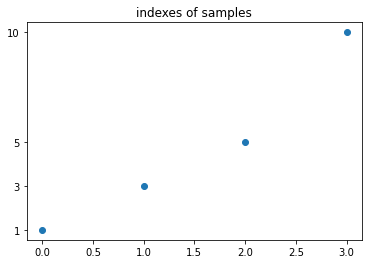

In [31]:
# plt.figure(figsize = (10,10))
plt.plot(opt_indexes_grid, 'o')
plt.yticks(opt_indexes_grid)
plt.title('indexes of samples')
plt.show()

# Small image example

In [105]:
c, d = 60, 60
L = p.graphs.Grid2d(c,d)
image_k = 800

In [106]:
paths = ['imgs/im_proc/square_pikachu.png']
image = np.flip(cv2.imread(paths[0]), axis = -1)/255

In [107]:
start_graph(reference_operator_grid, L)

In [ ]:
%%time
opt_indexes_image = optimal_sampling_operator(L.V, image_k, image_k, verbose = True)

3599
3598
3597
3596
3595
3594
3593
3592
3591
3590
3589
3588
3587
3586
3585
3584
3583
3582
3581
3580
3579
3578
3577
3576
3575
3574
3573
3572
3571
3570
3569
3568
3567
3566
3565
3564
3563
3562
3561
3560
3559
3558
3557
3556
3555
3554
3553
3552
3551
3550
3549
3548
3547
3546
3545
3544
3543
3542
3541
3540
3539
3538
3537
3536
3535
3534
3533
3532
3531
3530
3529
3528
3527
3526
3525
3524
3523
3522
3521
3520
3519
3518
3517
3516
3515
3514
3513
3512
3511
3510
3509
3508
3507
3506
3505
3504
3503
3502
3501
3500
3499
3498
3497
3496
3495
3494
3493
3492
3491
3490
3489
3488
3487
3486
3485
3484
3483
3482
3481
3480
3479
3478
3477
3476
3475
3474
3473
3472
3471
3470
3469
3468
3467
3466
3465
3464
3463
3462
3461
3460
3459
3458
3457
3456
3455
3454
3453
3452
3451
3450
3449
3448
3447
3446
3445
3444
3443
3442
3441
3440
3439
3438
3437
3436
3435
3434
3433
3432
3431
3430
3429
3428
3427
3426
3425
3424
3423
3422
3421
3420
3419
3418
3417
3416
3415
3414
3413
3412
3411
3410
3409
3408
3407
3406
3405
3404
3403
3402
3401
3400


In [ ]:
%%time
V_image, Λ_image, ψ_image, U_image, φ_image = setup(reference_operator_grid, L, opt_indexes_image)
ψ_sampling_image = sampling_matrix(L.V, opt_indexes_image)
M_image = φ_image @ ψ_image

In [ ]:
r = image[:,:,0].reshape(c * d)
g = image[:,:,1].reshape(c * d)
b = image[:,:,2].reshape(c * d)

In [ ]:
plt.plot((V_image.T @ b).real[:800]) #vamos dizer que 800 é a maior frequencia das 3 cores

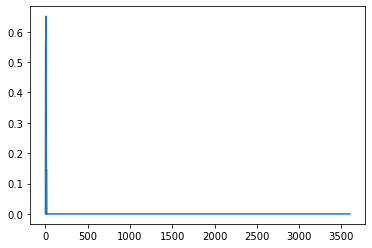

In [104]:
plt.(ψ_sampling_image @ r)